# Stan implementation of Bivariate Beta model

Comparing different stan implementations. 

In [1]:
import os
import tqdm
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import arviz as az

from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path
# Setting the cmdstan path
set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

import sys
sys.path.append('../scripts/python')
    
from parameter_estimation import BivariateBeta

## Stan integrator

We first verify the integrator from Stan, if it is working well, ina robust way and how fast it can go.

First, let's analyze the `integrate_1d` function from Stan. We defined four different variations: 

1. The integrand is $u^{\alpha_1-1}(x-u)^{\alpha_2-1}(y-u)^{\alpha_3-1}(1-x-y+u)^{\alpha_4-1}$
2. The integrand is $\exp\{(\alpha_1-1)\cdot\log(u) + (\alpha_2-1)\cdot\log(x-u) + (\alpha_3-1)\cdot\log(y-u) + (\alpha_4-1)\cdot\log(1-x-y+u)\}$
3. The integrand is $u^{\alpha_1-1}(x-u)^{\alpha_2-1}(y-u)^{\alpha_3-1}(1-x-y+u)^{\alpha_4-1}$, but using the high precision parameter `xc` which is the distance between $u$ and the closest limit. For instance, if $u$ is close to $x < y$, we have $xc = x-u$, with more precision.
4. The integrand is$\exp\{(\alpha_1-1)\cdot\log(u) + (\alpha_2-1)\cdot\log(x-u) + (\alpha_3-1)\cdot\log(y-u) + (\alpha_4-1)\cdot\log(1-x-y+u)\}$, but using the high precision parameter `xc` which is the distance between $u$ and the closest limit.

In [2]:
stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-density.stan')
model = CmdStanModel(stan_file=stanfile)

INFO:cmdstanpy:found newer exe file, not recompiling


In [20]:
alpha = np.random.gamma(1,1,size=4)
n = 10000
XY = np.random.random(size=(n,2))
data = {'n': n, 'xy': XY, 'tolerance': 1e-10, 'alpha': alpha, 'integrand': 1}

In [22]:
data['integrand']=1
fit = model.sample(data=data, fixed_param=True, chains=1, iter_sampling=1)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [23]:
data['integrand']=2
fit = model.sample(data=data, fixed_param=True, chains=1, iter_sampling=1)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [24]:
data['integrand']=3
fit = model.sample(data=data, fixed_param=True, chains=1, iter_sampling=1)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [25]:
data['integrand']=4
fit = model.sample(data=data, fixed_param=True, chains=1, iter_sampling=1)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


We want to compare with the Appell F1 implementation in Python. Both are numerical approximations to the true value, however the implementation below is more robust. 

In [29]:
biv_beta_object = BivariateBeta(alpha=alpha)

quantities_scipy = np.zeros((n,1))
for i in tqdm.tqdm(range(n)):
    quantities_scipy[i,0] = np.log(float(biv_beta_object.pdf_appell(XY[i,0], XY[i,1])))
quantities_scipy = np.array(quantities_scipy)

100%|█████████████████████████████████████| 10000/10000 [04:37<00:00, 36.05it/s]


The maximum percentage error is approximetaly 33% (with this value of $\alpha$).

In [47]:
quantities_stan = fit.summary()['Mean'].values[1:].reshape(-1,1)
np.max(np.abs(quantities_scipy - quantities_stan)/quantities_scipy)

0.3366695938583487

## Stan model

Here we have three different versions of the Stan implementation:

- (v1) it incorporates the integration
- (v2) it uses the idea presented in the paper
- (v3) it slightly modify (v2) to have u|$\alpha \sim$ Uniform($\Omega$)model

In [52]:
stanfile1 = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v1.stan')
model_v1 = CmdStanModel(stan_file=stanfile1, cpp_options={'STAN_THREADS':'true'})

stanfile2 = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v2.stan')
model_v2 = CmdStanModel(stan_file=stanfile2, cpp_options={'STAN_THREADS':'true'})

stanfile3 = os.path.join('..', 'scripts','stan', 'bivariate-beta-model-v3.stan')
model_v3 = CmdStanModel(stan_file=stanfile3, cpp_options={'STAN_THREADS':'true'})

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling


## Quick verifications

Here we generate fake data to test the Stan functions

In [53]:
true_alpha = np.array([1,1,1,1])
n = 50
U = np.random.dirichlet(true_alpha, size=n)
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]
XY = np.column_stack([X,Y])

# Gamma hyperparameters
a = np.array([1,1,1,1])
b = 0.1*np.array([1,1,1,1])

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.5*np.ones(4)
lambd = np.ones(4)
c = 100*np.ones(4)

data = {'n': n, 'xy': XY, 
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

## Model V1

In [54]:
model_fit_v1 = model_v1.sample(data=data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [55]:
print(model_fit_v1.diagnose())

Processing csv files: /tmp/tmp0jfwbhs7/bivariate-beta-model-v1-20220711135715_1.csv, /tmp/tmp0jfwbhs7/bivariate-beta-model-v1-20220711135715_2.csv, /tmp/tmp0jfwbhs7/bivariate-beta-model-v1-20220711135715_3.csv, /tmp/tmp0jfwbhs7/bivariate-beta-model-v1-20220711135715_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [56]:
df = model_fit_v1.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],1.2,0.0049,0.25,0.82,1.2,1.6,2503.0,4.7,1.0
alpha[2],1.1,0.0047,0.22,0.72,1.0,1.5,2218.0,4.2,1.0
alpha[3],1.3,0.0054,0.26,0.90,1.3,1.7,2260.0,4.3,1.0
alpha[4],1.1,0.0047,0.23,0.73,1.1,1.5,2481.0,4.7,1.0


In [57]:
inf_data = az.from_cmdstanpy(model_fit_v1)

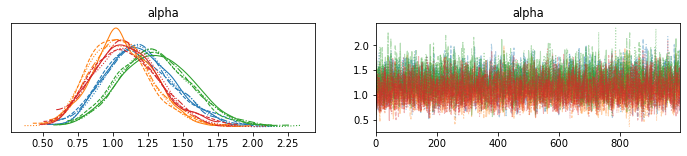

In [58]:
az.plot_trace(inf_data)
plt.show()

## Model V2

In [59]:
model_fit_v2 = model_v2.sample(data=data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [60]:
print(model_fit_v2.diagnose())

Processing csv files: /tmp/tmp0jfwbhs7/bivariate-beta-model-v2-20220711140247_1.csv, /tmp/tmp0jfwbhs7/bivariate-beta-model-v2-20220711140247_2.csv, /tmp/tmp0jfwbhs7/bivariate-beta-model-v2-20220711140247_3.csv, /tmp/tmp0jfwbhs7/bivariate-beta-model-v2-20220711140247_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [61]:
df = model_fit_v2.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],1.2,0.0065,0.24,0.82,1.2,1.6,1368.0,631.0,1.0
alpha[2],1.1,0.0054,0.21,0.74,1.1,1.4,1569.0,723.0,1.0
alpha[3],1.3,0.0062,0.25,0.91,1.3,1.7,1608.0,741.0,1.0
alpha[4],1.1,0.0064,0.23,0.75,1.1,1.5,1304.0,601.0,1.0


## Model V3

In [62]:
model_fit_v3 = model_v3.sample(data=data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [63]:
print(model_fit_v3.diagnose())

Processing csv files: /tmp/tmp0jfwbhs7/bivariate-beta-model-v3-20220711140256_1.csv, /tmp/tmp0jfwbhs7/bivariate-beta-model-v3-20220711140256_2.csv, /tmp/tmp0jfwbhs7/bivariate-beta-model-v3-20220711140256_3.csv, /tmp/tmp0jfwbhs7/bivariate-beta-model-v3-20220711140256_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [64]:
df = model_fit_v3.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],1.2,0.0068,0.25,0.82,1.2,1.6,1358.0,565.0,1.0
alpha[2],1.1,0.0056,0.22,0.72,1.1,1.5,1575.0,655.0,1.0
alpha[3],1.3,0.0060,0.26,0.92,1.3,1.8,1846.0,768.0,1.0
alpha[4],1.1,0.0065,0.23,0.75,1.1,1.5,1301.0,541.0,1.0


## Comparing v1 and v2

They should provide similar estimates for the same data.

In [65]:
comparing = ['Mean', '5%', '50%', '95%']
diff = abs(model_fit_v1.summary()[comparing].iloc[1:5] - model_fit_v2.summary()[comparing].iloc[1:5])
diff = diff/model_fit_v1.summary()[comparing].iloc[1:5]
# the percentage error is
diff

,Mean,5%,50%,95%
name,,,,
alpha[1],0.0,0.000000,0.0,0.000000
alpha[2],0.0,0.027778,0.1,0.066667
alpha[3],0.0,0.011111,0.0,0.000000
alpha[4],0.0,0.027397,0.0,0.000000
